In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [15, 7]
import seaborn as sns

In [2]:
from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme

In [3]:
set_nb_theme("chesterish")

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% ! important; }<style>"))

In [ ]:
url = "https://raw.githubusercontent.com/sinanuozdemir/feature_engineering_bookcamp/main/data/cleaned_airline_tweets.csv"
path = 'C:/Users/phuc2/Downloads/Documents/Machine Learning/Tweets.csv'

[1 2 3]


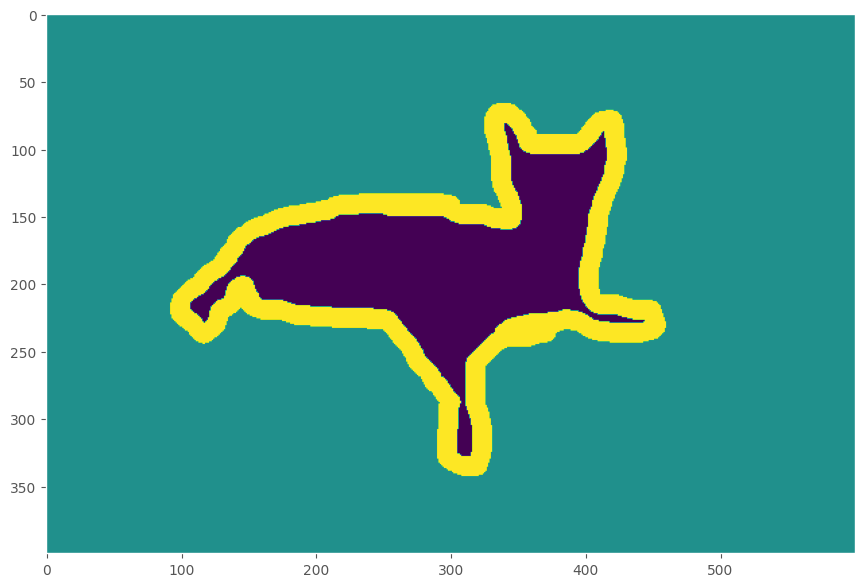

In [5]:
import cv2

mask_path = './semantic_segmentation/annotations/trimaps/Abyssinian_1.png'
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
plt.grid(False)
plt.imshow(mask)
print(np.unique(mask))

(400, 600, 3)


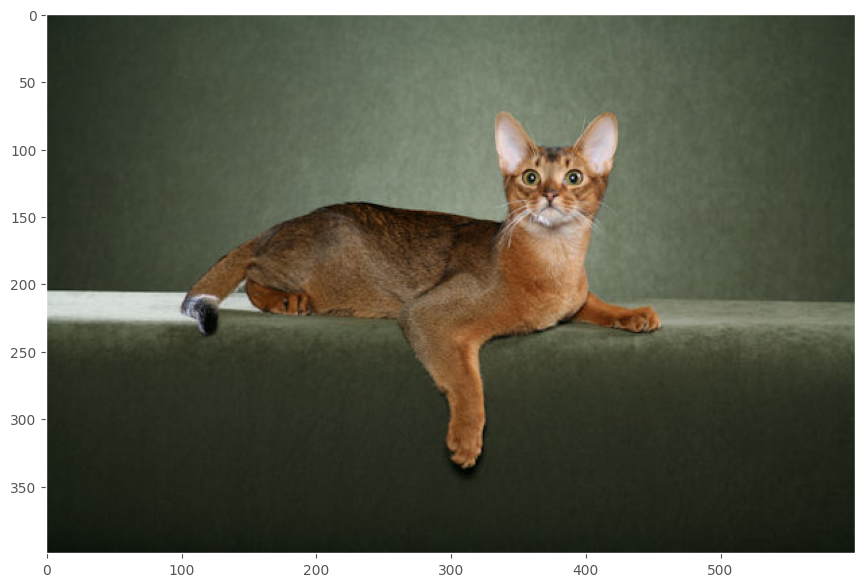

In [6]:
image_path = './semantic_segmentation/images/Abyssinian_1.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.grid(False)
plt.imshow(image)
print(image.shape)

In [7]:
from albumentations.pytorch import ToTensorV2
import albumentations as A

IMG_SIZE = 384

train_transform = A.Compose([
    A.Resize(width=IMG_SIZE, height=IMG_SIZE),
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.Blur(),
    A.Sharpen(),
    A.RGBShift(),
    A.Cutout(num_holes=5, max_h_size=25, max_w_size=25, fill_value=0),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(width=IMG_SIZE, height=IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255),
    ToTensorV2()
])

In [8]:
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch
import glob
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class DogCatDataset(Dataset):
    # transform: augmentation + norm + np.array -> torch.tensor
    def __init__(self, root_dir, txt_file, transform=None):
        super().__init__()
        self.root_dir = root_dir
        self.txt_file = txt_file
        self.transform = transform
        self.img_path_lst = []
        with open(self.txt_file) as file_in:
            for line in file_in:
                self.img_path_lst.append(line.split(' ')[0])
                
    def __len__(self):
        return len(self.img_path_lst)
    
    def __getitem__(self, ix):
        image_path = os.path.join(
            self.root_dir, 
            'semantic_segmentation', 
            'images', 
            '{}.jpg'.format(self.img_path_lst[ix])
        )
        mask_path = os.path.join(
            self.root_dir,
            'semantic_segmentation',
            'annotations',
            'trimaps',
            '{}.png'.format(self.img_path_lst[ix])
        )
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask[mask == 2] = 0
        mask[mask == 3] = 1
        
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            transformed_image = transformed['image']
            transformed_mask = transformed['mask']
        
        return transformed_image, transformed_mask

In [9]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        
    def __call__(self, tensor):
        for t,m,s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalized code -> t.sub_(m).div_(s)
        return tensor
    
unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

In [10]:
train_dataset = DogCatDataset('./', './semantic_segmentation/annotations/trainval.txt', transform=train_transform)
test_dataset = DogCatDataset('./', './semantic_segmentation/annotations/test.txt', transform=test_transform)

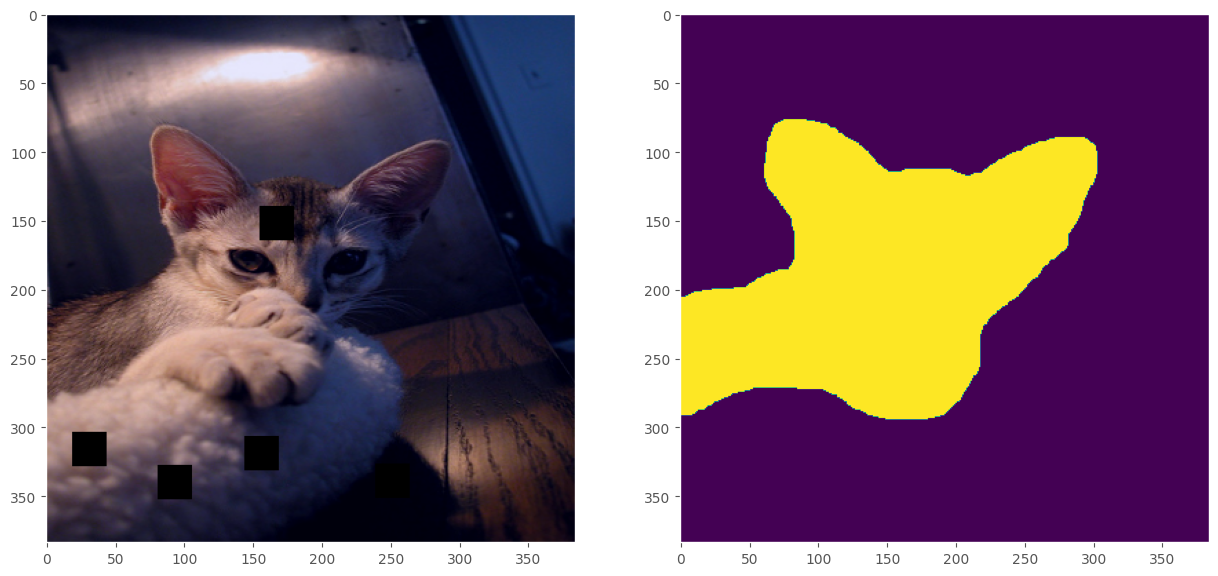

In [11]:
image, mask = train_dataset.__getitem__(10)
image = image.float()
plt.subplot(1, 2, 1)
plt.grid(False)
plt.imshow(unorm(image).permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.grid(False)
plt.imshow(mask)

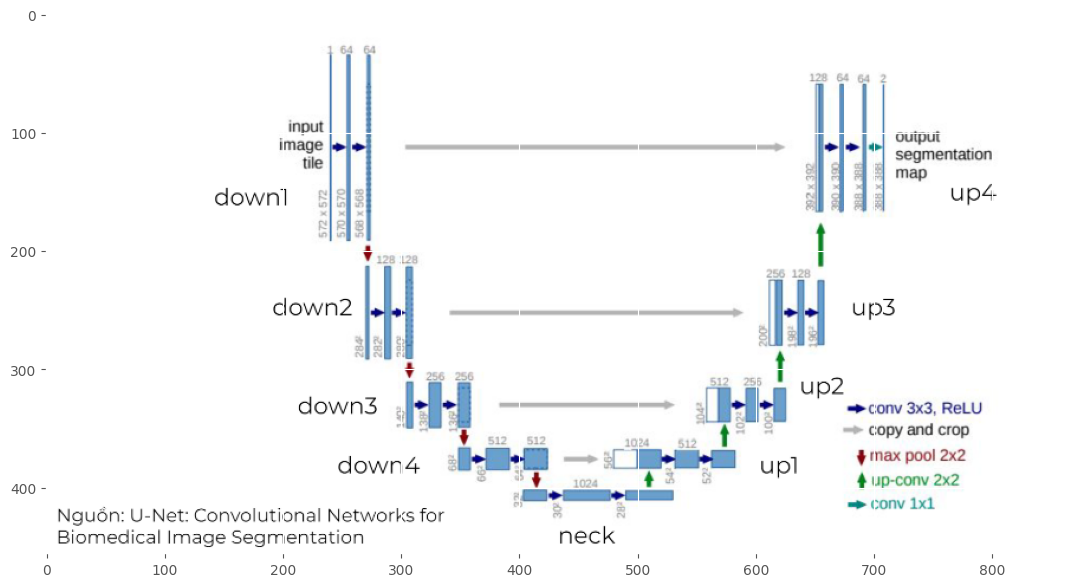

In [12]:
unet_structure = cv2.imread('C:/Users/phuc2/Downloads/unet.png')
unet_structure = cv2.cvtColor(unet_structure, cv2.COLOR_BGR2RGB)
plt.imshow(unet_structure)

In [13]:
def unet_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.ReLU()
    )

class UNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.n_classes = n_classes
        self.downsample = nn.MaxPool2d(kernel_size=2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.down1 = unet_block(3, 64)
        self.down2 = unet_block(64, 128)
        self.down3 = unet_block(128, 256)
        self.down4 = unet_block(256, 512)
        self.neck = unet_block(512, 1024)
        self.up1 = unet_block(512 + 1024, 512)
        self.up2 = unet_block(256 + 512, 256)
        self.up3 = unet_block(128 + 256, 128)
        self.up4 = unet_block(64 + 128, 64)
        self.conv_cls = nn.Conv2d(64, n_classes, kernel_size=1)
        
    def forward(self, x):
        # Downsampling path
        x1 = self.down1(x)
        x = self.downsample(x1)
        x2 = self.down2(x)
        x = self.downsample(x2)
        x3 = self.down3(x)
        x = self.downsample(x3)
        x4 = self.down4(x)
        x = self.downsample(x4)
        
        x = self.neck(x)
        
        # Upsampling path
        x = torch.cat([x4, self.upsample(x)], dim=1)
        x = self.up1(x)
        x = torch.cat([x3, self.upsample(x)], dim=1)
        x = self.up2(x)
        x = torch.cat([x2, self.upsample(x)], dim=1)
        x = self.up3(x)
        x = torch.cat([x1, self.upsample(x)], dim=1)
        x = self.up4(x)
        
        x = self.conv_cls(x)
        return x

In [14]:
class AverageMeter(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [15]:
def accuracy_function(preds, targets):
    acc = torch.sum(preds == targets)
    return acc / targets.shape[0]

In [16]:
from torch.optim import Adam
from torchmetrics import Dice, JaccardIndex

trainloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

model = UNet(1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

dice_fn = Dice(num_classes=2, average='macro').to(device)
iou_fn = JaccardIndex(num_classes=2, task='binary', average='macro').to(device)

acc_meter = AverageMeter()
train_loss_meter = AverageMeter()
dice_meter = AverageMeter()
iou_meter = AverageMeter()

In [17]:
from tqdm import tqdm

for ep in range(1, 31):
    acc_meter.reset()
    train_loss_meter.reset()
    dice_meter.reset()
    iou_meter.reset()
    model.train()

    for batch_id, (x, y) in enumerate(tqdm(trainloader), start=1):
        n = x.shape[0]
        x = x.to(device).float()
        y = y.to(device).float()
        y_hat = model(x)
        y_hat = y_hat.squeeze()
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        with torch.no_grad():
            y_hat_mask = y_hat.sigmoid().round().long()
            dice_score = dice_fn(y_hat_mask, y.long())
            iou_score = iou_fn(y_hat_mask, y.long())
            accuracy = accuracy_function(y_hat_mask, y.long())

            train_loss_meter.update(loss.item(), n)
            iou_meter.update(iou_score.item(), n)
            dice_meter.update(dice_score.item(), n)
            acc_meter.update(accuracy.item(), n)

    print("EP {}, train loss = {}, accuracy = {}, IoU = {}, dice = {}".format(
        ep, train_loss_meter.avg, acc_meter.avg, iou_meter.avg, dice_meter.avg
    ))
    if ep >= 25:
        torch.save(model.state_dict(), "/content/model_ep_{}.pth".format(ep))

  0%|          | 0/460 [00:08<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 288.00 MiB (GPU 0; 6.00 GiB total capacity; 4.55 GiB already allocated; 0 bytes free; 5.14 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
test_iou_meter = AverageMeter()
test_dice_meter = AverageMeter()

model.eval()
with torch.no_grad():
    for batch_id, (x, y) in enumerate(tqdm(testloader), start=1):
        n = x.shape[0]
        x = x.to(device).float()
        y = y.to(device).float()
        y_hat = model(x)
        y_hat = y_hat.squeeze()
        y_hat_mask = y_hat.sigmoid().round().long()
        dice_score = dice_fn(y_hat_mask, y.long())
        iou_score = iou_fn(y_hat_mask, y.long())
        test_dice_meter.update(dice_score.item(), n)
        test_iou_meter.update(iou_score.item(), n)
print("TEST: IoU = {}, dice = {}".format(test_iou_meter.avg, test_dice_meter.avg))

In [ ]:
import random

model.eval()
idx = random.randint(0, 100)
with torch.no_grad():
    x, y = test_dataset[idx]
    # print(x.shape, y.shape) (C, H, W) -> (1, C, H, W) -> model
    x = x.to(device).float().unsqueeze(0)
    y_hat = model(x).squeeze() #(1, 1, H, W) -> (H, W)
    y_hat_mask = y_hat.sigmoid().round().long()
    # x, y, y_hat_mask
    plt.subplot(1, 3, 1)
    plt.imshow(unorm(x.squeeze().cpu()).permute(1, 2, 0)) # x (GPU) -> x(CPU)
    plt.subplot(1, 3, 2)
    plt.imshow(y)
    plt.subplot(1, 3, 3)
    plt.imshow(y_hat_mask.cpu())